**Short description**

In this notebook we will find similar cards based on their text (`filteredText`).
A simple `Doc2Vec` model will generate feature vectors from the text given our dataset.
We experiment with PCA and UMAP for dimensionality reduction and projection in a 2d plane. Similar cards are mined using the KNN algorithm and stored to MongoDB for later exploration.

- - -

# Imports

In [1]:
import sys

In [2]:
sys.path.append('../config')
import config
import mongo

## General 

In [3]:
import gensim
from gensim import corpora
from pprint import pprint
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import numpy as np
import sklearn
import pandas as pd
import umap
from pymongo import MongoClient
from sklearn.neighbors import NearestNeighbors
import tqdm
import pickle

/home/vagrant/venv/lib/python3.6/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [4]:
pd.options.display.max_colwidth = 1000

# Read Data 

In [5]:
keyruneCode = "M21"

In [6]:
df = spark.read.parquet(f'{config.OUTPUT_DATASET}/{keyruneCode}_cards.parquet')

In [7]:
as_dict = df.rdd.map(lambda row: row.asDict())

In [8]:
cards = as_dict.collect()

In [9]:
num_cards = len(cards)

# Tokenize

In [10]:
field_text = "filteredText"

data_list = [{'number': card['number'], 'text': card[field_text], 'name': card['name']} 
             for card in cards if field_text in card if card[field_text] is not None
            ]
card_names = list(map(lambda card: card['number'], data_list))
data = list(map(lambda card: card['text'], data_list))

In [11]:
tagged_data = [
    TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)])
    for i, _d in enumerate(data) if _d is not None
]

In [12]:
num_tagged_cards = len(tagged_data)

# Train model

In [13]:
max_epochs = 100
vec_size = 50
alpha = 0.0125

In [14]:
model = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm=1)
model.build_vocab(tagged_data)

In [15]:
for epoch in tqdm.tqdm(range(max_epochs)):
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    model.alpha -= 0.0002
    model.min_alpha = model.alpha

100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


In [16]:
X = list()

for i in tqdm.tqdm(range(len(model.docvecs))):
    X.append(model.docvecs[i])
docvecs = np.array(X)

100%|██████████| 280/280 [00:00<00:00, 168204.69it/s]


# Project and embed data

In [17]:
rng = np.random.RandomState(0)

In [18]:
pca = sklearn.decomposition.PCA(random_state=rng)
pca_docvecs = pca.fit_transform(docvecs)

In [19]:
mdl_umap = umap.UMAP(n_neighbors=25, metric='cosine', random_state=rng, transform_seed=rng)
embedded_docvecs = mdl_umap.fit_transform(docvecs)

In [20]:
# with open("../mdl_umap.pickle","wb") as fp:
#     pickle.dump(mdl_umap, fp)
# fp.close()

# Find similar cards (up to 20)

In [21]:
similarity_results = list()

for card, embedded_vector in zip(cards, embedded_docvecs):
    knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
    knn.fit(embedded_docvecs)
    
    distances, neighs_ids = knn.kneighbors(np.reshape(embedded_vector, [1, 2]), 10, return_distance=True)
    
    neighs_ids = neighs_ids.astype(np.int32)[0]
    resolve_cards = np.array(cards)[neighs_ids].tolist()
    resolve_cards_ids = list(map(lambda kvp: kvp['number'], resolve_cards))
    
    similarity_results.append({'card_number': card['number'], 'similar': resolve_cards_ids})

# Save feature vectors 

In [22]:
client = MongoClient(host=mongo.MONGODB_HOST)
db = client[mongo.MONGODB_DB]

In [23]:
feats = [{'number': card['number'], 'docvect': feature_vector.tolist(), 'embedded_vect': embedded_vector.tolist()} 
         for card, feature_vector, embedded_vector in zip(cards, docvecs, embedded_docvecs)
        ]

In [24]:
# db.ml.similar.feat_vecs.drop()
# result = db.ml.similar.feat_vecs.insert_many(feats)
# result.acknowledged

In [25]:
# db.ml.similar.cards.drop()
# result = db.ml.similar.cards.insert_many(similarity_results)
# result.acknowledged

# Plot cards in 2d

In [26]:
# pca = sklearn.decomposition.PCA(random_state=rng)
# pca_docvecs = pca.fit_transform(docvecs)

In [27]:
# mdl_umap = umap.UMAP(n_neighbors=10, metric='cosine', random_state=rng, transform_seed=rng)
# embedded_docvecs = mdl_umap.fit_transform(docvecs)

In [28]:
df = pd.DataFrame(np.hstack([embedded_docvecs, np.reshape(data, [num_tagged_cards, 1]), np.reshape(card_names, [num_tagged_cards, 1])]),
                  columns=['x', 'y', 'text', 'name'])

In [29]:
df['name'] = df['name'].astype(int)
df['text'] = df['text'].astype(str)

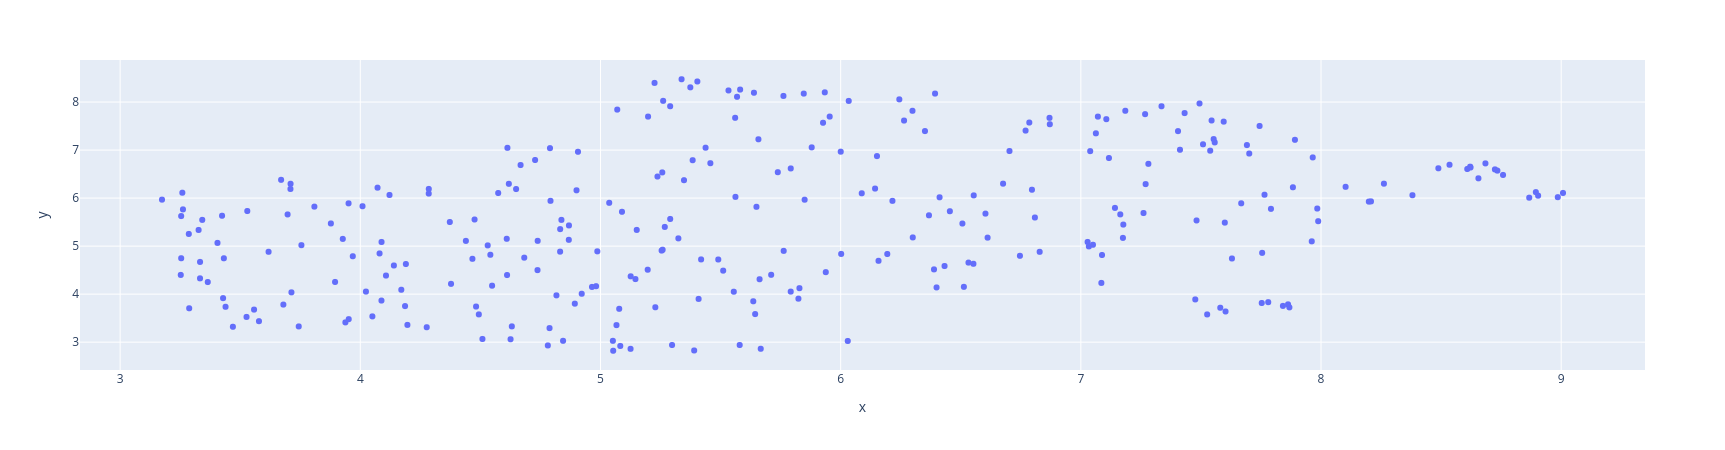

In [30]:
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)

fig = px.scatter(data_frame=df, x='x', y='y', hover_data=['name', 'text'])
fig.show()

In [31]:
umap_results = []

for ii, row in enumerate(similarity_results):    
    card_number = row['card_number']
    similar = row['similar']
    
    row_cards = {}
    row_cards['Source'] = df[df['name'] == card_number].text.to_string(index=False).strip()
    
    for i, s in enumerate(similar):
        if i == 0:
            continue
            
        row_cards[f'Target {i}'] = df[df['name'] == s].text.to_string(index=False).strip().replace("\\n", "<br/>")
    
    umap_results.append(row_cards)

In [32]:
df_umap = pd.DataFrame(umap_results, columns=['Source'] + [f'Target {i + 1}' for i in range(4)])

In [33]:
df_tmp = df_umap.style.set_properties(**{'white-space': 'pre-wrap', 'align': 'left'})

In [34]:
df_tmp

,Source,Target 1,Target 2,Target 3,Target 4
0,"Hexproof from Black\nWhenever CARDNAME deals combat damage to a player or planeswalker, look at that many cards from the top of your library. You may reveal a creature card or Garruk planeswalker card from among them and put it into your hand. Put the rest on the bottom of your library in a random order.","Whenever you cast a noncreature spell, you may have CARDNAME become a 3/3 Sphinx creature with flying in addition to its other types until end of turn.PAY_2{U}: Scry 1. (Look at the top card of your library. You may put that card on the bottom of your library.)","As CARDNAME enters the battlefield, choose a card name.You have protection from the chosen card name. (You can't be targeted, dealt damage, or enchanted by anything with that name.)","[+1]: Discard your hand, then exile the top three cards of your library. Until end of turn, you may play cards exiled this way.[+1]: CARDNAME deals 2 damage to any target.[−9]: Search your graveyard and library for any number of red instant and/or sorcery spells, exile them, then shuffle your library. You may cast them this turn. Add six {R}.","As long as it's your turn, CARDNAME has first strike.You may look at the top card of your library any time, and you may play lands from the top of your library.PAY_4{R}{G}: Radha gets +X/+X until end of turn, where X is the number of lands you control."
1,Target creature gets +1/+1 and gains your choice of deathtouch or lifelink until end of turn. (Any amount of damage a creature with deathtouch deals to a creature is enough to destroy it. Damage dealt by a creature with lifelink also causes its controller to gain that much life.),Tap up to two target creatures. Those creatures don't untap during their controller's next untap step.,"FLASHETB_EFFECT, draw X cards, where X is the number of creatures that died under your control this turn.",PAY_5{W}: Tap target creature. This ability costs PAY_1 less to activate for each Shrine you control.,"You may spend mana as though it were mana of any color.TAP: Add {C}{C}{C}{C}{C}.PAY_5, TAP: Draw a card for each color among permanents you control."
2,"As long as it's your turn, CARDNAME has first strike.\nYou may look at the top card of your library any time, and you may play lands from the top of your library.\nPAY_4{R}{G}: Radha gets +X/+X until end of turn, where X is the number of lands you control.","As CARDNAME enters the battlefield, choose a card name.You have protection from the chosen card name. (You can't be targeted, dealt damage, or enchanted by anything with that name.)","Series([], )","At the beginning of your end step, if you control a creature with power 4 or greater, exile the top card of your library. You may play that card until you exile another card with CARDNAME.","Hexproof from BlackWhenever CARDNAME deals combat damage to a player or planeswalker, look at that many cards from the top of your library. You may reveal a creature card or Garruk planeswalker card from among them and put it into your hand. Put the rest on the bottom of your library in a random order."
3,"FLASH\nWhenever CARDNAME or another Rogue enters the battlefield under your control, each opponent mills two cards.\nAs long as an opponent has eight or more cards in their graveyard, CARDNAME gets +2/+1 and has deathtouch.","If one or more +1/+1 counters would be put on a creature you control, that many plus one +1/+1 counters are put on that creature instead.When CARDNAME dies, you gain life equal to its power.","VIGILANCE, protection from multicoloredETB_EFFECT, put a +1/+1 counter on target creature you control.Whenever CARDNAME or another creature you control dies, if it had a +1/+1 counter on it, create a 2/2 white Knight creature token with vigilance.","CARDNAME enters the battlefield with X +1/+1 counters on it.Whenever one or more +1/+1 counters are put on another non-Hydra creature you control, put a +1/+1 counter on CARDNAME.","[+1]: CARDNAME deals 3 damage to each 